In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import sys
sys.path.append('../')
import geometry
from geometry import geometry

In [43]:
# each entry in the "spots" dictionary needs to be an array with one entry per spot, 
# so for a single spot we build a dictionary with one-element arrays for each field.
def make_spot(z, phi, rho):

    h = z * jnp.cos(phi)
    k = z * jnp.sin(phi)
    a = rho
    b = rho * jnp.sqrt(1 - z**2)
    theta = jnp.pi/2 + phi

    return {'center': jnp.array([jnp.array([h, k])]), 'a': jnp.array([a]), 'b': jnp.array([b]), 'theta': jnp.array([theta])}

def move_planet(planet, dx, dy):

    center = planet['center'] + jnp.array([dx, dy])
    return {'center': center, 'a': planet['a'], 'b': planet['b'], 'theta': planet['theta']}

spot = make_spot(0.835, np.pi / 3, 0.3)

rad = 0.2
planet = {'center': jnp.array([jnp.array([-1, 0])]), 'a': jnp.array([rad]), 'b': jnp.array([rad]), 'theta': jnp.array([jnp.pi / 2])}

dx = jnp.linspace(0, 2, 100)
dy = jnp.linspace(0, 1.0, 100)
planet_frames = jax.vmap(move_planet, in_axes=(None, 0, 0))(planet, dx, dy)

body_func = lambda spot, planet: (spot, geometry.build_geometry(spot, planet))

In [44]:
jnp.sqrt(jnp.sum(spot['center']**2)) + spot['b']

Array([1.00007498], dtype=float64)

In [45]:
_, (interior, planet_spot, plimb, slimb) = jax.lax.scan(body_func, spot, planet_frames)

(-1.5, 1.5)

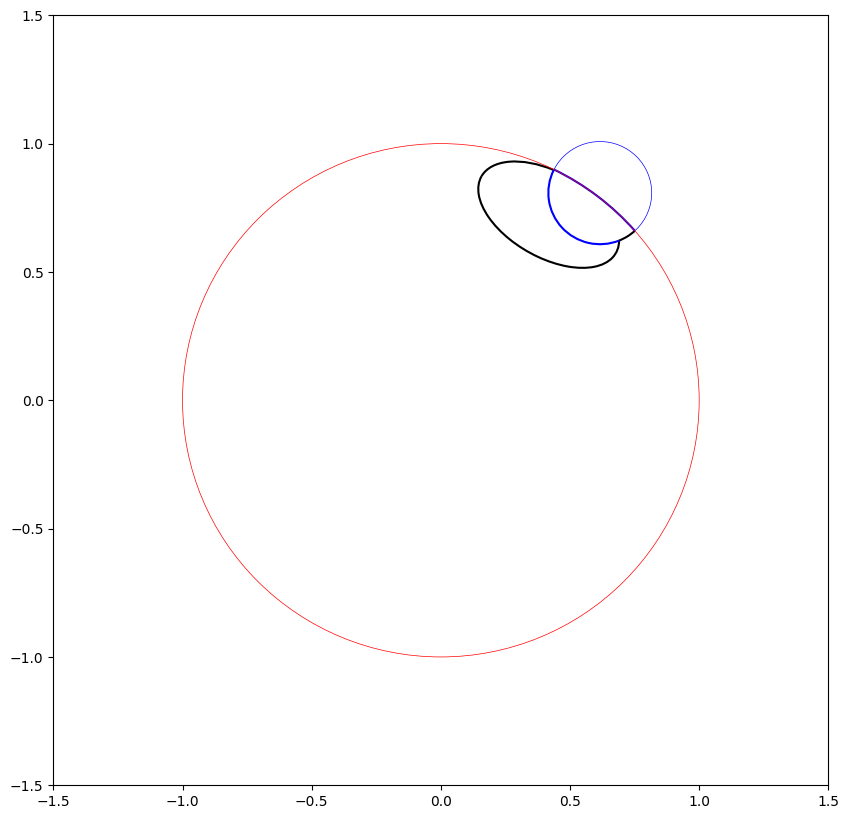

In [46]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Ellipse, Circle

j = 80

spot_dicts = [{
        'a':spot['a'][i], 
        'b':spot['b'][i], 
        'center':spot['center'][i], 
        'theta':spot['theta'][i],
    } for i in range(len(spot['a']))]

planet_dicts = [{
        'a':planet_frames['a'][j][i], 
        'b':planet_frames['b'][j][i], 
        'center':planet_frames['center'][j][i], 
        'theta':planet_frames['theta'][j][i],
    } for i in range(len(planet_frames['a'][j]))]

spots_and_planets_dicts = np.concatenate([spot_dicts, planet_dicts])

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

ax.add_patch(Circle(
    planet_frames['center'][j][0],
    planet_frames['a'][j][0],
    fill=False,
    linewidth=0.5,
    alpha=1.0,
    color='b'
))

for ellipse, arcset in zip(spots_and_planets_dicts, interior[j]):
    for a in arcset:
        if ~jnp.isnan(a[0]):
            ax.add_patch(Arc(
                    ellipse['center'], 
                    ellipse['a'] * 2, 
                    ellipse['b'] * 2, 
                    angle=ellipse['theta'] * 180 / np.pi, 
                    theta1=a[0] * 180 / np.pi, 
                    theta2=a[1] * 180 / np.pi,
                    linewidth=1.5
                ))

for a in planet_spot[j][0]:
    if ~jnp.isnan(a[0]):
        ax.add_patch(Arc(
                ellipse['center'], 
                ellipse['a'] * 2, 
                ellipse['b'] * 2, 
                angle=ellipse['theta'] * 180 / np.pi, 
                theta1=a[0] * 180 / np.pi, 
                theta2=a[1] * 180 / np.pi,
                linewidth=1.5,
                color='b'
            ))

for a in slimb[j]:
    if ~jnp.isnan(a[0]):
        ax.add_patch(Arc(
                (0, 0), 
                2, 
                2, 
                theta1=a[0] * 180 / np.pi, 
                theta2=a[1] * 180 / np.pi,
                linewidth=1.5,
                color='r'
            ))

for a in plimb[j]:
    if ~jnp.isnan(a[0]):
        ax.add_patch(Arc(
                (0, 0), 
                2, 
                2, 
                theta1=a[0] * 180 / np.pi, 
                theta2=a[1] * 180 / np.pi,
                linewidth=1.5,
                color='b'
            ))

ax.add_patch(Circle(
    (0.0, 0.0),
    1.0,
    fill=False,
    linewidth=0.5,
    alpha=1.0,
    color='r'
))

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [47]:
import integration
from integration import integration

In [48]:
c1 = 0.2
c2 = 0.1

integrate_spot = lambda ellipse, lim: (
    ellipse, integration.ellipse_arc(
        (c1, c2), ellipse['a'], ellipse['b'], jnp.sqrt(jnp.sum(ellipse['center']**2)), lim
    )
)

integrate_planet = lambda circle, lim: (
    circle, integration.circle_arc(
        (c1, c2), circle['a'], jnp.sqrt(jnp.sum(circle['center']**2)), lim
    )
)

In [49]:
planet_frame_dicts = [{
        'a':planet_frames['a'][j][1], 
        'b':planet_frames['b'][j][1], 
        'center':planet_frames['center'][j][1], 
        'theta':planet_frames['theta'][j][1],
    } for j in range(100)]

_, f1 = jax.lax.scan(integrate_spot, spot, interior[j][0])
line_integral_spots = jnp.nansum(f1)

In [50]:
f1

Array([[nan],
       [nan],
       [nan],
       [nan]], dtype=float64)

In [ ]:
interior[j][1]

In [ ]:
integration.circle_arc((c1, c2), planet_frame_dicts[j]['a'], jnp.sqrt(jnp.sum(planet_frame_dicts[j]['center']**2)), interior[j][1][0])

In [ ]:
integration.circle(planet_frame_dicts[j]['a'], jnp.sqrt(jnp.sum(planet_frame_dicts[j]['center']**2)), *interior[j][1][0])

In [ ]:
phi1, phi2 = interior[j][1][0]
s1 = jnp.sin(phi1)
s2 = jnp.sin(phi2)
c1 = jnp.cos(phi1)    
c2 = jnp.cos(phi2)
conditions = jnp.array([
        (c1 > 0) & (c2 > 0) & (s1 > s2), # C
        (c1 > 0) & (c2 > 0),             # A/F
        (c1 > 0) & (c2 < 0),             # B
        (c1 < 0) & (c2 < 0),             # D
        (c1 < 0) & (c2 > 0)              # E
    ])
conditions

In [ ]:
import integration
from integration import linear

In [ ]:
r, z = planet_frame_dicts[j]['a'], jnp.sqrt(jnp.sum(planet_frame_dicts[j]['center']**2))
a = r + 0.001
b = r
c = jnp.sqrt(a * a - b * b)
oc2 = 1 / (c * c)
f = (1 - a * a - z * z) * oc2
g = -2 * b * z * oc2
linear.int4(s1, s2, f, g)

In [ ]:
a2 = (1 - (r**2 + z**2)) / (2 * r * z)
x = s2
y = s1
    
d12 = a2 - 1
d13 = 2
d23 = a2 + 1

x1 = jnp.sqrt(1 - x)
x2 = jnp.sqrt(a2 - x)
x3 = jnp.sqrt(1 + x)

y1 = jnp.sqrt(1 - y)
y2 = jnp.sqrt(a2 - y)
y3 = jnp.sqrt(1 + y)